<a href="https://colab.research.google.com/github/heroza/Skin-Cancer-Diagnosis/blob/main/Skin_Cancer_Diagnosis_using_ISIC_2018_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare the dataset. 
Currently, we use skin cancer ISIC dataset from Kaggle https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

Tutorial for how to load Kaggle dataset can be found in https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Data

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout, Flatten
from tensorflow.keras.models import Model

!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import SMOTE

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv') 
df_val = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv') 
num_classes = 7
#df_train

In [5]:
#decode one hot label
df_train["Labels"] = (df_train.iloc[:, 1:]).idxmax(axis=1)
df_val["Labels"] = (df_val.iloc[:, 1:]).idxmax(axis=1)

#drop one-hot column
df_train = df_train.drop(columns=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])
df_val = df_val.drop(columns=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])

#make filepaths of the image
dir_train = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_Input/'
dir_val = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Validation_Input/'
df_train['FilePaths'] = dir_train + df_train['image'] + '.jpg'
df_val['FilePaths'] = dir_val + df_val['image'] + '.jpg'

In [8]:
df_train

,image,Labels,FilePaths
0,ISIC_0024306,NV,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
1,ISIC_0024307,NV,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
2,ISIC_0024308,NV,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
3,ISIC_0024309,NV,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
4,ISIC_0024310,MEL,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
...,...,...,...
10010,ISIC_0034316,MEL,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
10011,ISIC_0034317,MEL,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
10012,ISIC_0034318,BKL,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
10013,ISIC_0034319,NV,/content/drive/MyDrive/PHD/Datasets/isic2018/I...


Label Distribution

[Text(0, 0, 'DF'),
 Text(0, 0, 'VASC'),
 Text(0, 0, 'AKIEC'),
 Text(0, 0, 'BCC'),
 Text(0, 0, 'BKL'),
 Text(0, 0, 'MEL'),
 Text(0, 0, 'NV')]

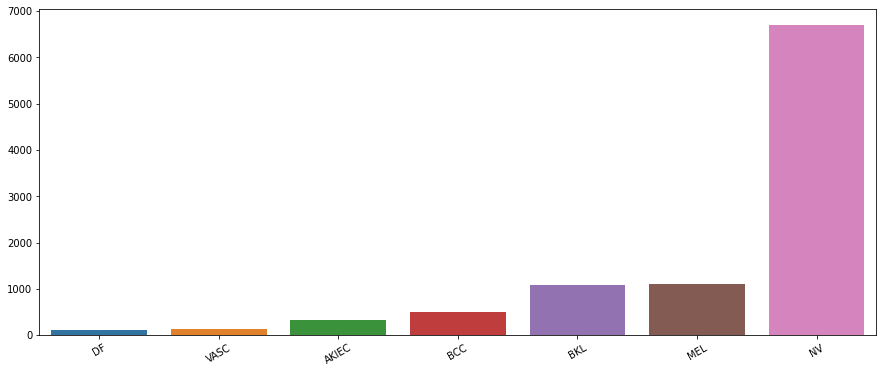

In [9]:
# ordered count of rows per unique label
labels_count = df_train['Labels'].value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

Plot 3 images per label

In [10]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df_train['Labels'].unique())
for label in labels:
    plot_images_per_label(df_train, label, 3, (12,9))

Dataset Balancer

In [ ]:
print(imblearn.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Prepare X,y

In [12]:
# input image size
IMAGE_W = 32
IMAGE_H = 32
IMG_SIZE = (IMAGE_W,IMAGE_H)

In [13]:
#TIME CONSUMING OPERATION
#from tensorflow.keras.preprocessing.image import load_img, img_to_array
#X = []
#for img in df['FilePaths']:
    #img_arr = load_img(img, target_size=IMG_SIZE)
#    with load_img(img, target_size=IMG_SIZE) as img_arr:
#      X.append(img_to_array(img_arr))

#X = np.array(X)
df_train['image'] = df_train['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))
df_val['image'] = df_val['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))


In [62]:
#X_val = []
#for img in df_val['FilePaths']:
#    with load_img(img, target_size=IMG_SIZE) as img_arr:
#      X_val.append(img_to_array(img_arr))

#X_val = np.array(X_val)
X_train = np.asarray(df_train['image'].tolist())
X_val = np.asarray(df_val['image'].tolist())
print(np.array(X_train).shape)
print(np.array(X_val).shape)

(10015, 32, 32, 3)
(193, 32, 32, 3)


In [69]:
#Normalization
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)

X_train = (X_train - X_train_mean)/X_train_std
X_val = (X_val - X_train_mean)/X_train_std

In [63]:
y_train = np.array(df_train['Labels'].values)

# summarize class distribution
from collections import Counter
counter = Counter(y_train)
print(counter)
print(y_train.shape)

Counter({'NV': 6705, 'MEL': 1113, 'BKL': 1099, 'BCC': 514, 'AKIEC': 327, 'VASC': 142, 'DF': 115})
(10015,)


In [64]:
y_val = np.array(df_val['Labels'].values)
print(Counter(y_val))
print(y_val.shape)

Counter({'NV': 123, 'BKL': 22, 'MEL': 21, 'BCC': 15, 'AKIEC': 8, 'VASC': 3, 'DF': 1})
(193,)


In [65]:
#label encoding
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)
y_train

array([5, 5, 5, ..., 2, 5, 5])

SMOTE Oversampling

In [47]:
def SMOTE_Data(X, y):
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X.reshape((-1, IMAGE_W * IMAGE_H * 3)), y)
    X_resampled.reshape(-1, IMAGE_W, IMAGE_H, 3)
    return X_resampled, y_resampled

In [48]:
X_train, y_train = SMOTE_Data(X_train, y_train) #beware of the actual parameter
print(X_train.shape)
print(y_train.shape)

(46935, 3072)
(46935, 7)


In [53]:
counter = Counter(y_train[:,0])
print(counter)

Counter({0: 40230, 1: 6705})


In [54]:
X_train = X_train.reshape(-1, IMAGE_W, IMAGE_H, 3)
print('X_train shape: ',X_train.shape)

X_train shape:  (46935, 32, 32, 3)


DeepSMOTE Oversampling

In [ ]:
X_train

In [72]:
#optional
X=X_train
y=y_train

from numpy import moveaxis
dec_x = moveaxis(X, 3, 1)
#dec_x = dec_x.astype('float32') / 255.
#dec_x = X_train 
dec_y = y

#create counter for encoder
counter = sorted(counter.items())
counter = [value for _, value in counter]

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from sklearn.neighbors import NearestNeighbors
import time
import os

print(torch.version.cuda) #10.1

args = {}
args['dim_h'] = 64         # factor controlling size of hidden layers
args['n_channel'] = 3#1    # number of channels in the input data 

args['n_z'] = 600 #300     # number of dimensions in latent space. 

args['sigma'] = 1.0        # variance in n_z
args['lambda'] = 0.01      # hyper param for weight of discriminator loss
args['lr'] = 0.0002        # learning rate for Adam optimizer .000
args['epochs'] = 100       # how many epochs to run for
args['batch_size'] = 32   # batch size for SGD
args['save'] = True        # save weights at each epoch of training if True
args['train'] = True       # train networks if True, else load networks from

## create encoder model and decoder model
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            #nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 0, bias=False),
            
            #3d and 32 by 32
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 1, 0, bias=False),
            
            nn.BatchNorm2d(self.dim_h * 8), # 40 X 8 = 320
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True) )#,
            #nn.Conv2d(self.dim_h * 8, 1, 2, 1, 0, bias=False))
            #nn.Conv2d(self.dim_h * 8, 1, 4, 1, 0, bias=False))
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)
        

    def forward(self, x):
        #print('enc')
        #print('input ',x.size()) #torch.Size([100, 3,32,32])
        x = self.conv(x)
        
        x = x.squeeze()
        #print('aft squeeze ',x.size()) #torch.Size([128, 320])
        #aft squeeze  torch.Size([100, 320])
        x = self.fc(x)
        #print('out ',x.size()) #torch.Size([128, 20])
        #out  torch.Size([100, 300])
        return x


class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 2**4 * 8 * 8),
            nn.ReLU())

        # deconvolutional filters, essentially inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 16, self.dim_h * 8, 4),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 3, 4, stride=2, padding=2),
            #nn.Sigmoid())
            nn.Tanh())

    def forward(self, x):
        #print('dec')
        #print('input ',x.size())
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 2**4, 8, 8)
        x = self.deconv(x)
        return x

##############################################################################
"""set models, loss functions"""
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False


##############################################################################
"""functions to create SMOTE images"""

def biased_get_class(c):
    
    xbeg = dec_x[dec_y == c]
    ybeg = dec_y[dec_y == c]
    
    return xbeg, ybeg
    #return xclass, yclass


def G_SM(X, y,n_to_sample,cl):

    # determining the number of samples to generate
    #n_to_sample = 10 

    # fitting the model
    n_neigh = 5 + 1
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(X)
    dist, ind = nn.kneighbors(X)

    # generating samples
    base_indices = np.random.choice(list(range(len(X))),n_to_sample)
    neighbor_indices = np.random.choice(list(range(1, n_neigh)),n_to_sample)

    X_base = X[base_indices]
    X_neighbor = X[ind[base_indices, neighbor_indices]]

    samples = X_base + np.multiply(np.random.rand(n_to_sample,1),
            X_neighbor - X_base)

    #use 10 as label because 0 to 9 real classes and 1 fake/smoted = 10
    return samples, [cl]*n_to_sample

#xsamp, ysamp = SM(xclass,yclass)

#Begin the training
batch_size = args['batch_size']
encoder = Encoder(args)
decoder = Decoder(args)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
decoder = decoder.to(device)
encoder = encoder.to(device)

train_on_gpu = torch.cuda.is_available()

#decoder loss function
criterion = nn.MSELoss()
criterion = criterion.to(device)

num_workers = 0

#torch.Tensor returns float so if want long then use torch.tensor
tensor_x = torch.Tensor(dec_x)
tensor_y = torch.tensor(dec_y,dtype=torch.long)
mnist_bal = TensorDataset(tensor_x,tensor_y) 
train_loader = torch.utils.data.DataLoader(mnist_bal, 
    batch_size=batch_size,shuffle=True,num_workers=num_workers)

best_loss = np.inf

t0 = time.time()
if args['train']:
    enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
    dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])

    for epoch in range(args['epochs']):
        train_loss = 0.0
        tmse_loss = 0.0
        tdiscr_loss = 0.0
        # train for one epoch -- set nets to train mode
        encoder.train()
        decoder.train()
    
        for images,labs in train_loader:
        
            # zero gradients for each batch
            encoder.zero_grad()
            decoder.zero_grad()
            images, labs = images.to(device), labs.to(device)
            labsn = labs.detach().cpu().numpy()
#            print('images shape', images.shape)
            # run images
            z_hat = encoder(images)
#            print('images shape after encoding', z_hat.shape)
        
            x_hat = decoder(z_hat) #decoder outputs tanh
#            print('images shape after decoding', x_hat.shape)
            mse = criterion(x_hat,images)
                    
            resx = []
            resy = []
        
            tc = np.random.choice(num_classes,1)
            #tc = 9
            xbeg = dec_x[dec_y == tc]
            ybeg = dec_y[dec_y == tc] 
            xlen = len(xbeg)
            nsamp = min(xlen, 100)
            ind = np.random.choice(list(range(len(xbeg))),nsamp,replace=False)
            xclass = xbeg[ind]
            yclass = ybeg[ind]
        
            xclen = len(xclass)
            xcminus = np.arange(1,xclen)
            
            xcplus = np.append(xcminus,0)
            xcnew = (xclass[[xcplus],:])
            xcnew = xcnew.reshape(xcnew.shape[1],xcnew.shape[2],xcnew.shape[3],xcnew.shape[4])
        
            xcnew = torch.Tensor(xcnew)
            xcnew = xcnew.to(device)
        
            #encode xclass to feature space
            xclass = torch.Tensor(xclass)
            xclass = xclass.to(device)
            xclass = encoder(xclass)
        
            xclass = xclass.detach().cpu().numpy()
        
            xc_enc = (xclass[[xcplus],:])
            xc_enc = np.squeeze(xc_enc)
        
            xc_enc = torch.Tensor(xc_enc)
            xc_enc = xc_enc.to(device)
            
            ximg = decoder(xc_enc)
            
            mse2 = criterion(ximg,xcnew)
        
            comb_loss = mse2 + mse
            comb_loss.backward()
        
            enc_optim.step()
            dec_optim.step()
        
            train_loss += comb_loss.item()*images.size(0)
            tmse_loss += mse.item()*images.size(0)
            tdiscr_loss += mse2.item()*images.size(0)

        train_loss = train_loss/len(train_loader)
        tmse_loss = tmse_loss/len(train_loader)
        tdiscr_loss = tdiscr_loss/len(train_loader)
        print('Epoch: {} \tTrain Loss: {:.6f} \tmse loss: {:.6f} \tmse2 loss: {:.6f}'.format(epoch,
                train_loss,tmse_loss,tdiscr_loss))
        
    
    
        #store the best encoder and decoder models
        #here, /crs5 is a reference to 5 way cross validation, but is not
        #necessary for illustration purposes
        if train_loss < best_loss:
            print('Saving..')
            path_enc = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/bst_enc.pth'
            path_dec = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/bst_dec.pth'
          
            torch.save(encoder.state_dict(), path_enc)
            torch.save(decoder.state_dict(), path_dec)
    
            best_loss = train_loss
    
    
    #in addition, store the final model (may not be the best) for
    #informational purposes
    path_enc = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/f_enc.pth'
    path_dec = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/f_dec.pth'
    print(path_enc)
    print(path_dec)
    torch.save(encoder.state_dict(), path_enc)
    torch.save(decoder.state_dict(), path_dec)


11.3
cuda
Epoch: 0 	Train Loss: 17.758066 	mse loss: 9.451456 	mse2 loss: 8.306611
Saving..
Epoch: 1 	Train Loss: 13.375766 	mse loss: 7.124884 	mse2 loss: 6.250882
Saving..
Epoch: 2 	Train Loss: 12.254844 	mse loss: 6.819355 	mse2 loss: 5.435488
Saving..
Epoch: 3 	Train Loss: 11.537239 	mse loss: 6.560107 	mse2 loss: 4.977132
Saving..
Epoch: 4 	Train Loss: 11.379381 	mse loss: 6.433396 	mse2 loss: 4.945985
Saving..
Epoch: 5 	Train Loss: 10.916566 	mse loss: 6.270719 	mse2 loss: 4.645847
Saving..
Epoch: 6 	Train Loss: 10.928581 	mse loss: 6.224287 	mse2 loss: 4.704294
Epoch: 7 	Train Loss: 10.523825 	mse loss: 6.143813 	mse2 loss: 4.380011
Saving..
Epoch: 8 	Train Loss: 10.213302 	mse loss: 6.047119 	mse2 loss: 4.166183
Saving..
Epoch: 9 	Train Loss: 10.288031 	mse loss: 6.002253 	mse2 loss: 4.285777
Epoch: 10 	Train Loss: 10.097670 	mse loss: 5.960416 	mse2 loss: 4.137254
Saving..
Epoch: 11 	Train Loss: 9.815287 	mse loss: 5.932556 	mse2 loss: 3.882731
Saving..
Epoch: 12 	Train Loss: 

In [ ]:
#Generate artificial images
import torch
np.printoptions(precision=5,suppress=True)

#path on the computer where the models are stored
modpth = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/'

encf = []
decf = []
for p in range(1):
    enc = modpth + '/bst_enc.pth'
    dec = modpth + '/bst_dec.pth'
    encf.append(enc)
    decf.append(dec)

for m in range(1):
    print('decy ',dec_y.shape)
    print('train imgs shape ',dec_x.shape) #(45000,3,32,32)
    
    #generate some images 
    train_on_gpu = torch.cuda.is_available()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    path_enc = encf[m]
    path_dec = decf[m]

    encoder = Encoder(args)
    encoder.load_state_dict(torch.load(path_enc), strict=False)
    encoder = encoder.to(device)

    decoder = Decoder(args)
    decoder.load_state_dict(torch.load(path_dec), strict=False)
    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()

    imbal = counter#[114, 376, 95, 438, 357, 462, 77, 181, 139]

    resx = []
    resy = []

    for i in [0,1,2,3,4,6]: #skip class 5 since it's max class
        torch.cuda.empty_cache()

        xclass, yclass = biased_get_class(i)
        print(xclass.shape) #(500, 3, 32, 32)
        print(yclass[0]) #(500,)
            
        #encode xclass to feature space
        xclass = torch.Tensor(xclass)
        xclass = xclass.to(device)
        xclass = encoder(xclass)
            
        xclass = xclass.detach().cpu().numpy()
        n = imbal[5] - imbal[i]
        xsamp, ysamp = G_SM(xclass,yclass,n,i)
        print(xsamp.shape) #(4500, 600)
        print(len(ysamp)) #4500
        ysamp = np.array(ysamp)
    
        """to generate samples for resnet"""   
        xsamp = torch.Tensor(xsamp)
        xsamp = xsamp.to(device)
        ximg = decoder(xsamp)

        ximn = ximg.detach().cpu().numpy()
        print(ximn.shape) 
        resx.append(ximn)
        resy.append(ysamp)
    
    resx1 = np.vstack(resx)
    resy1 = np.hstack(resy)
    print(resx1.shape) #(34720, 3, 32, 32)

    resx1 = resx1.reshape(resx1.shape[0],-1)
    print(resx1.shape) #(34720, 3072)
    
    dec_x1 = dec_x.reshape(dec_x.shape[0],-1)
    print('decx1 ',dec_x1.shape)
    combx = np.vstack((resx1,dec_x1))
    comby = np.hstack((resy1,dec_y))

    print(combx.shape) #(45000, 3, 32, 32)
    print(comby.shape) #(45000,)
    print()

In [ ]:
X_train = combx.reshape(-1, 3, IMAGE_W, IMAGE_H)
X_train = moveaxis(X_train, 1, 3)
print('X_train shape: ',X_train.shape)
print(Counter(comby))

Prepare for Classification

In [21]:
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
print('y_train shape: ',y_train.shape)

y_train shape:  (10015, 1)


In [36]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = num_classes)
y_val = to_categorical(y_val, num_classes = num_classes)

In [ ]:
X = X.astype(int)
X_val = X_val.astype(int)

In [ ]:
X_train[:1]

Split dataset to train and val

In [ ]:
# stratified train and rem (20%) datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.02, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Remaining Data: ', X_val.shape)

Train Data:  (9814, 32, 32, 3)
Remaining Data:  (201, 32, 32, 3)


In [ ]:
# stratified val and test (50%) 
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size=0.5, stratify=y_rem, random_state=1)

print('Test Data: ', X_test.shape)
print('Val Data: ', X_val.shape)

Test Data:  (416, 32, 32, 3)
Val Data:  (416, 32, 32, 3)


In [ ]:
#optional
# stratified train and test (10%) datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Test Data: ', X_test.shape)

Train Data:  (2015, 32, 32, 3)
Test Data:  (224, 32, 32, 3)


In [ ]:
#optional
# stratified train and val (10%) datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)

Train Data:  (3369, 32, 32, 3)
Val Data:  (375, 32, 32, 3)


In [ ]:
print(Counter(y_train[:,0]))

Counter({5: 6570, 4: 1091, 2: 1077, 1: 504, 0: 320, 6: 139, 3: 113})


Create and compile the model

# ResNet Transfer Learning
Model from https://github.com/AnasBrital98/CNN-From-Scratch/tree/master/Inception-V3

In [60]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

EPOCHS = 100
BATCH_SIZE = 50

#Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')

#Data Augmentation
dataaugment = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

dataaugment.fit(X_train)

In [61]:
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(IMAGE_H, IMAGE_W, 3))
# create the base pre-trained model
base_model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(7, activation='softmax')(x)
#predictions = Dense(9)(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# train the model on the new data for a few epochs
#hst = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val))

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
hst = model.fit(dataaugment.flow(X_train,y_train, batch_size=BATCH_SIZE),
                    epochs = EPOCHS, validation_data = (X_val,y_val),
                    steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                    callbacks=[learning_rate_reduction,early_stopping_monitor])

Epoch 1/100
938/938 [==============================] - 29s 28ms/step - loss: 1.7938 - accuracy: 0.2804 - val_loss: 1.5675 - val_accuracy: 0.4093 - lr: 0.0010
Epoch 2/100
938/938 [==============================] - 24s 26ms/step - loss: 1.6770 - accuracy: 0.3077 - val_loss: 1.6775 - val_accuracy: 0.3782 - lr: 0.0010
Epoch 3/100
938/938 [==============================] - 24s 26ms/step - loss: 1.6558 - accuracy: 0.3226 - val_loss: 1.6363 - val_accuracy: 0.3731 - lr: 0.0010
Epoch 4/100
938/938 [==============================] - 25s 27ms/step - loss: 1.6389 - accuracy: 0.3292 - val_loss: 1.4553 - val_accuracy: 0.4819 - lr: 0.0010
Epoch 5/100
938/938 [==============================] - 24s 26ms/step - loss: 1.6330 - accuracy: 0.3346 - val_loss: 1.6457 - val_accuracy: 0.2694 - lr: 0.0010
Epoch 6/100
938/938 [==============================] - 24s 26ms/step - loss: 1.6187 - accuracy: 0.3409 - val_loss: 1.6897 - val_accuracy: 0.3109 - lr: 0.0010
Epoch 7/100
938/938 [==============================]

In [ ]:
model.save('/content/drive/MyDrive/models')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/assets


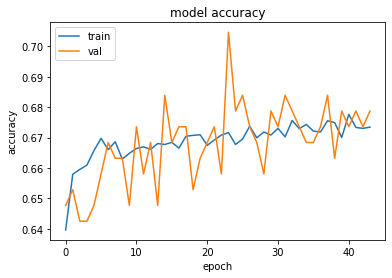

In [38]:
# summarize history for accuracy
plt.plot(hst.history['accuracy'])
plt.plot(hst.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [42]:
# we chose to train the top 2 resnet blocks, i.e. we will freeze
# the first 49 layers and unfreeze the rest:
limit = 171
for layer in model.layers[:limit]:
   layer.trainable = False
for layer in model.layers[limit:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
#model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=["accuracy"])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
#hst2 = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val))
optimizer_SGD = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer = optimizer_SGD , loss = "categorical_crossentropy", metrics=["accuracy"])
hst2 = model.fit(dataaugment.flow(X_train,y_train, batch_size=BATCH_SIZE),
                    epochs = EPOCHS, validation_data = (X_val,y_val),
                    steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                    callbacks=[learning_rate_reduction,early_stopping_monitor])

Epoch 1/100
500/500 [==============================] - 13s 17ms/step - loss: 1.1472 - accuracy: 0.6429 - val_loss: 1.0885 - val_accuracy: 0.6269 - lr: 1.0000e-04
Epoch 2/100
500/500 [==============================] - 8s 15ms/step - loss: 1.0733 - accuracy: 0.6574 - val_loss: 1.0622 - val_accuracy: 0.6477 - lr: 1.0000e-04
Epoch 3/100
500/500 [==============================] - 8s 16ms/step - loss: 1.0268 - accuracy: 0.6643 - val_loss: 1.0647 - val_accuracy: 0.6477 - lr: 1.0000e-04
Epoch 4/100
500/500 [==============================] - 8s 15ms/step - loss: 1.0137 - accuracy: 0.6673 - val_loss: 1.0914 - val_accuracy: 0.6528 - lr: 1.0000e-04
Epoch 5/100
500/500 [==============================] - 8s 15ms/step - loss: 1.0093 - accuracy: 0.6667 - val_loss: 1.0976 - val_accuracy: 0.6114 - lr: 1.0000e-04
Epoch 6/100
500/500 [==============================] - 8s 15ms/step - loss: 0.9939 - accuracy: 0.6708 - val_loss: 1.0236 - val_accuracy: 0.6477 - lr: 1.0000e-04
Epoch 7/100
500/500 [============

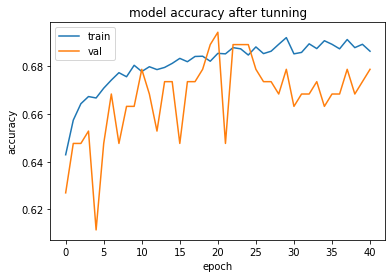

In [43]:
# summarize history for accuracy
plt.plot(hst2.history['accuracy'])
plt.plot(hst2.history['val_accuracy'])
plt.title('model accuracy after tunning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
# accuracy
print(f'Train Accuracy: {hst2.history["accuracy"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {hst2.history["val_accuracy"][-1:][0] * 100:.2f}')
# loss
print(f'Train Loss: {hst2.history["loss"][-1:][0] * 100:.2f}')
print(f'Val Loss: {hst2.history["val_loss"][-1:][0] * 100:.2f}')

Train Accuracy: 68.63
Val Accuracy: 67.88
Train Loss: 91.62
Val Loss: 98.10


Load test data

In [ ]:
X_test = load_data('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

Print head data

In [ ]:
X_test.head(3)

,FilePaths,Labels
0,Skin cancer ISIC The International Skin Imagin...,vascular lesion
1,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
2,Skin cancer ISIC The International Skin Imagin...,squamous cell carcinoma


In [ ]:
print('Test Data: ', X_test.shape)

# ordered count of rows per unique label
X_test['Labels'].value_counts(ascending=True)

Test Data:  (118, 2)


vascular lesion                3
seborrheic keratosis           3
pigmented benign keratosis    16
squamous cell carcinoma       16
actinic keratosis             16
melanoma                      16
nevus                         16
dermatofibroma                16
basal cell carcinoma          16
Name: Labels, dtype: int64

Preprocess test image

In [ ]:
X_test_arr = []
for img in X_test['FilePaths']:
    loaded_img = load_img(img, target_size=IMG_SIZE)
    img_arr = img_to_array(loaded_img)
    X_test_arr.append(img_arr)
    
print(np.array(X_test_arr).shape)  
y_test = X_test['Labels']
X_test = X_test_arr

y_test = np.array(y_test.values)
X_test = np.array(X_test)

(118, 224, 224, 3)


In [ ]:
#resampling test set

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42, k_neighbors=2)
X_test, y_test = sm.fit_resample(X_test.reshape((-1, IMAGE_W * IMAGE_H * 3)), y_test)
X_test.reshape(-1, IMAGE_W, IMAGE_H, 3)
print(X_test.shape)
print(y_test.shape)

(144, 150528)
(144,)


In [ ]:
X_test

array([[171.     , 149.     , 170.     , ...,  37.     ,  34.     ,
         53.     ],
       [172.     , 135.     , 169.     , ..., 173.     , 138.     ,
        171.     ],
       [184.     , 149.     , 155.     , ..., 198.     , 158.     ,
        166.     ],
       ...,
       [190.80458, 136.39708, 150.79555, ..., 131.82196,  90.41307,
        102.2114 ],
       [204.09334, 129.02664, 138.69998, ..., 195.18666, 128.88664,
        135.74664],
       [204.05249, 128.57738, 138.39366, ..., 195.10498, 128.49864,
        135.4199 ]], dtype=float32)

In [ ]:
X_test = X_test.reshape(-1, IMAGE_W, IMAGE_H, 3)

In [ ]:
y_test = y_test.reshape(-1,1)
y_test= label_encoder.fit_transform(y_test)
y_test

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([8, 5, 7, 0, 3, 5, 4, 2, 1, 0, 5, 5, 2, 4, 6, 1, 0, 5, 2, 0, 4, 3,
       4, 7, 3, 5, 2, 2, 0, 7, 1, 1, 3, 0, 4, 0, 1, 2, 5, 3, 0, 1, 2, 7,
       3, 2, 4, 7, 3, 0, 1, 7, 1, 3, 2, 7, 4, 7, 7, 1, 7, 3, 8, 6, 2, 5,
       5, 0, 5, 4, 4, 3, 7, 5, 3, 2, 7, 3, 0, 8, 2, 1, 1, 3, 1, 0, 4, 7,
       2, 7, 4, 1, 0, 7, 2, 5, 4, 3, 3, 3, 1, 2, 5, 0, 0, 4, 0, 2, 5, 5,
       4, 5, 7, 1, 4, 4, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

In [ ]:
#y_test = y_test.reshape(-1,1)

In [ ]:
#X_test = X_test.astype('float32') / 255.

Evaluate model againts test data

In [ ]:
res = model.evaluate(X_test,y_test)

7/7 [==============================] - 1s 15ms/step - loss: 3.5914 - accuracy: 0.4509


The accuracy

In [ ]:
# accuracy
print(f'Train Accuracy: {hst2.history["accuracy"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {hst2.history["val_accuracy"][-1:][0] * 100:.2f}')
print(f'Test Accuracy: {res[1] * 100:.2f}')
# loss
print(f'Train Loss: {hst2.history["loss"][-1:][0] * 100:.2f}')
print(f'Val Loss: {hst2.history["val_loss"][-1:][0] * 100:.2f}')
print(f'Test Loss: {res[0] * 100:.2f}')

Train Accuracy: 95.73
Val Accuracy: 73.07
Test Accuracy: 45.09
Train Loss: 9.05
Val Loss: 161.83
Test Loss: 359.14


Calculate y_pred from training and testing for analysis

In [ ]:
# predicted labels
Y_pred = model.predict(X_val)
print("Y_pred", Y_pred.shape)
# rounded labels
y_pred = np.argmax(Y_pred, axis=1)
print("y_pred", y_pred.size)

Y_pred (193, 9)
y_pred 193


In [ ]:
# predicted labels
Y_pred2 = model.predict(X_test)
print("Y_pred2", Y_pred2.shape)
# rounded labels
y_pred2 = np.argmax(Y_pred2, axis=1)
print("y_pred2", y_pred2.size)

Y_pred2 (224, 9)
y_pred2 224


Calculate y_true

In [ ]:
# true labels
#y_true = X_test.classes
print("y_pred", len(y_pred))
# label classes
#class_labels = list(X_test.class_indices.keys())
print("labels", len(y_val))

y_pred 193
labels 193


In [ ]:
y_pred[:10]

array([5, 5, 0, 5, 5, 5, 5, 5, 5, 5])

F1 Score

In [ ]:
print('Score on val data: ',precision_recall_fscore_support(y_val, y_pred, average='macro'))
#print('Score on test data: ',precision_recall_fscore_support(y_test, y_pred2, average='macro'))

Score on val data:  (0.5306913674560734, 0.3937889346425932, 0.42846503137856523, None)


The confusion metric

In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_val, y_pred)

print(cf_matrix)

[[  3   2   2   0   0   1   0]
 [  5   6   3   1   0   0   0]
 [  2   0   8   0   3   9   0]
 [  0   0   0   0   0   1   0]
 [  0   1   4   1   7   8   0]
 [  1   0   3   1   1 117   0]
 [  0   2   0   0   0   0   1]]


In [ ]:
cf_matrix2 = confusion_matrix(y_test, y_pred2)
print(cf_matrix2)

[[ 3  2  1  0  4  0  0  1  0]
 [ 2 16  0  4  0  7  0  6  3]
 [ 2  1  4  1  0  0  0  1  0]
 [ 0  2  0 25  4  5  7  1  0]
 [ 5  1  0  6 19  4  0  1  0]
 [ 3 10  2  4  1 18  1  5  2]
 [ 0  0  0  8  0  0  0  0  0]
 [ 4  5  0  2  0  1  0  6  0]
 [ 0  2  0  0  1  0  0  1 10]]


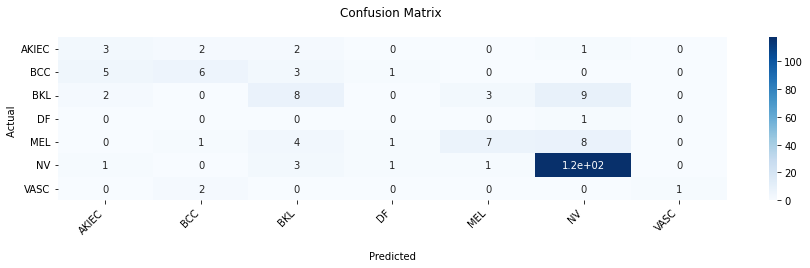

In [ ]:
ax = sns.heatmap(cf_matrix, annot=True, 
            cmap='Blues')

ax.set_title('Confusion Matrix \n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])
ax.yaxis.set_ticklabels(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])

plt.rcParams["figure.figsize"] = (15,3)

## Display the visualization of the Confusion Matrix.
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()

[Text(0, 0, 'AKIEC'),
 Text(0, 0, 'BCC'),
 Text(0, 0, 'BKL'),
 Text(0, 0, 'DF'),
 Text(0, 0, 'MEL'),
 Text(0, 0, 'NV'),
 Text(0, 0, 'VASC')]

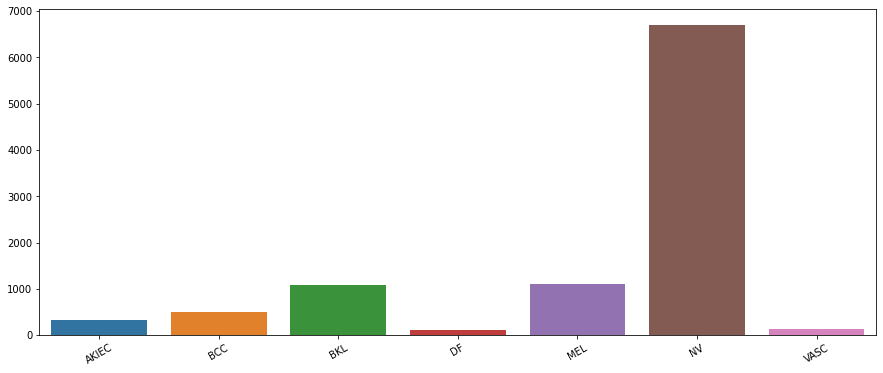

In [ ]:
# ordered count of rows per unique label
labels_count = df['Labels'].value_counts().sort_index()

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)